In [1]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl, seaborn.apionly as sns
import pcmdpy as ppy
from scipy.stats import lognorm
%matplotlib inline

GPU acceleration enabled


In [2]:
ppy.gpu_utils.initialize_gpu(n=0)

using given n: 0
Starting SourceModule Code
Past the SourceModule code
CUDAC Available


In [3]:
f = ppy.instrument.m31_filters()
iso_model = ppy.isochrones.Isochrone_Model(f)
driv = ppy.driver.Driver(iso_model, gpu=True)

In [4]:
mu = [-2., -1., 0., 1., 3.]
sig = [0.1, 1., 10.]

In [5]:
gm = ppy.galaxy.CustomGalaxy(ppy.metalmodels.SingleFeH, ppy.dustmodels.LogNormDust, ppy.agemodels.SSPModel)
gals = np.array([[gm.get_model(np.array([0., a, b, 5., 10.])) for b in sig] for a in mu])

In [6]:
for g in gals.flatten():
    print(g.dust_model.get_params())

(0.5, -4.605170185988092, 0.1)
(0.5, -4.605170185988092, 1.0)
(0.5, -4.605170185988092, 10.0)
(0.5, -2.302585092994046, 0.1)
(0.5, -2.302585092994046, 1.0)
(0.5, -2.302585092994046, 10.0)
(0.5, 0.0, 0.1)
(0.5, 0.0, 1.0)
(0.5, 0.0, 10.0)
(0.5, 2.302585092994046, 0.1)
(0.5, 2.302585092994046, 1.0)
(0.5, 2.302585092994046, 10.0)
(0.5, 6.907755278982138, 0.1)
(0.5, 6.907755278982138, 1.0)
(0.5, 6.907755278982138, 10.0)


In [7]:
nr = len(mu)
nc = len(sig)

In [18]:
N_im = 1024

In [19]:
pcmds = np.zeros((nr, nc, 2, N_im*N_im))
ims = np.zeros((nr, nc, 2, N_im, N_im))

In [20]:
%%time
for i in range(nr):
    for j in range(nc):
        pcmds[i,j], ims[i,j] = driv.simulate(gals[i][j], N_im, psf=True, fixed_seed=True, downsample=20)

CPU times: user 14.7 s, sys: 3.31 s, total: 18 s
Wall time: 19.5 s


In [21]:
fig, axes = plt.subplots(ncols=nc, nrows=nr, figsize=(20, 20))
for i in range(nr):
    for j in range(nc):
        axes[i,j].imshow(ims[i,j,0], cmap='Greys_r')
plt.tight_layout()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [22]:
colors = pcmds[:,:,1,:]
mags = pcmds[:,:,0,:]
bins = [np.linspace(colors.min(), colors.max(), 100), np.linspace(mags.min(), mags.max(), 100)]

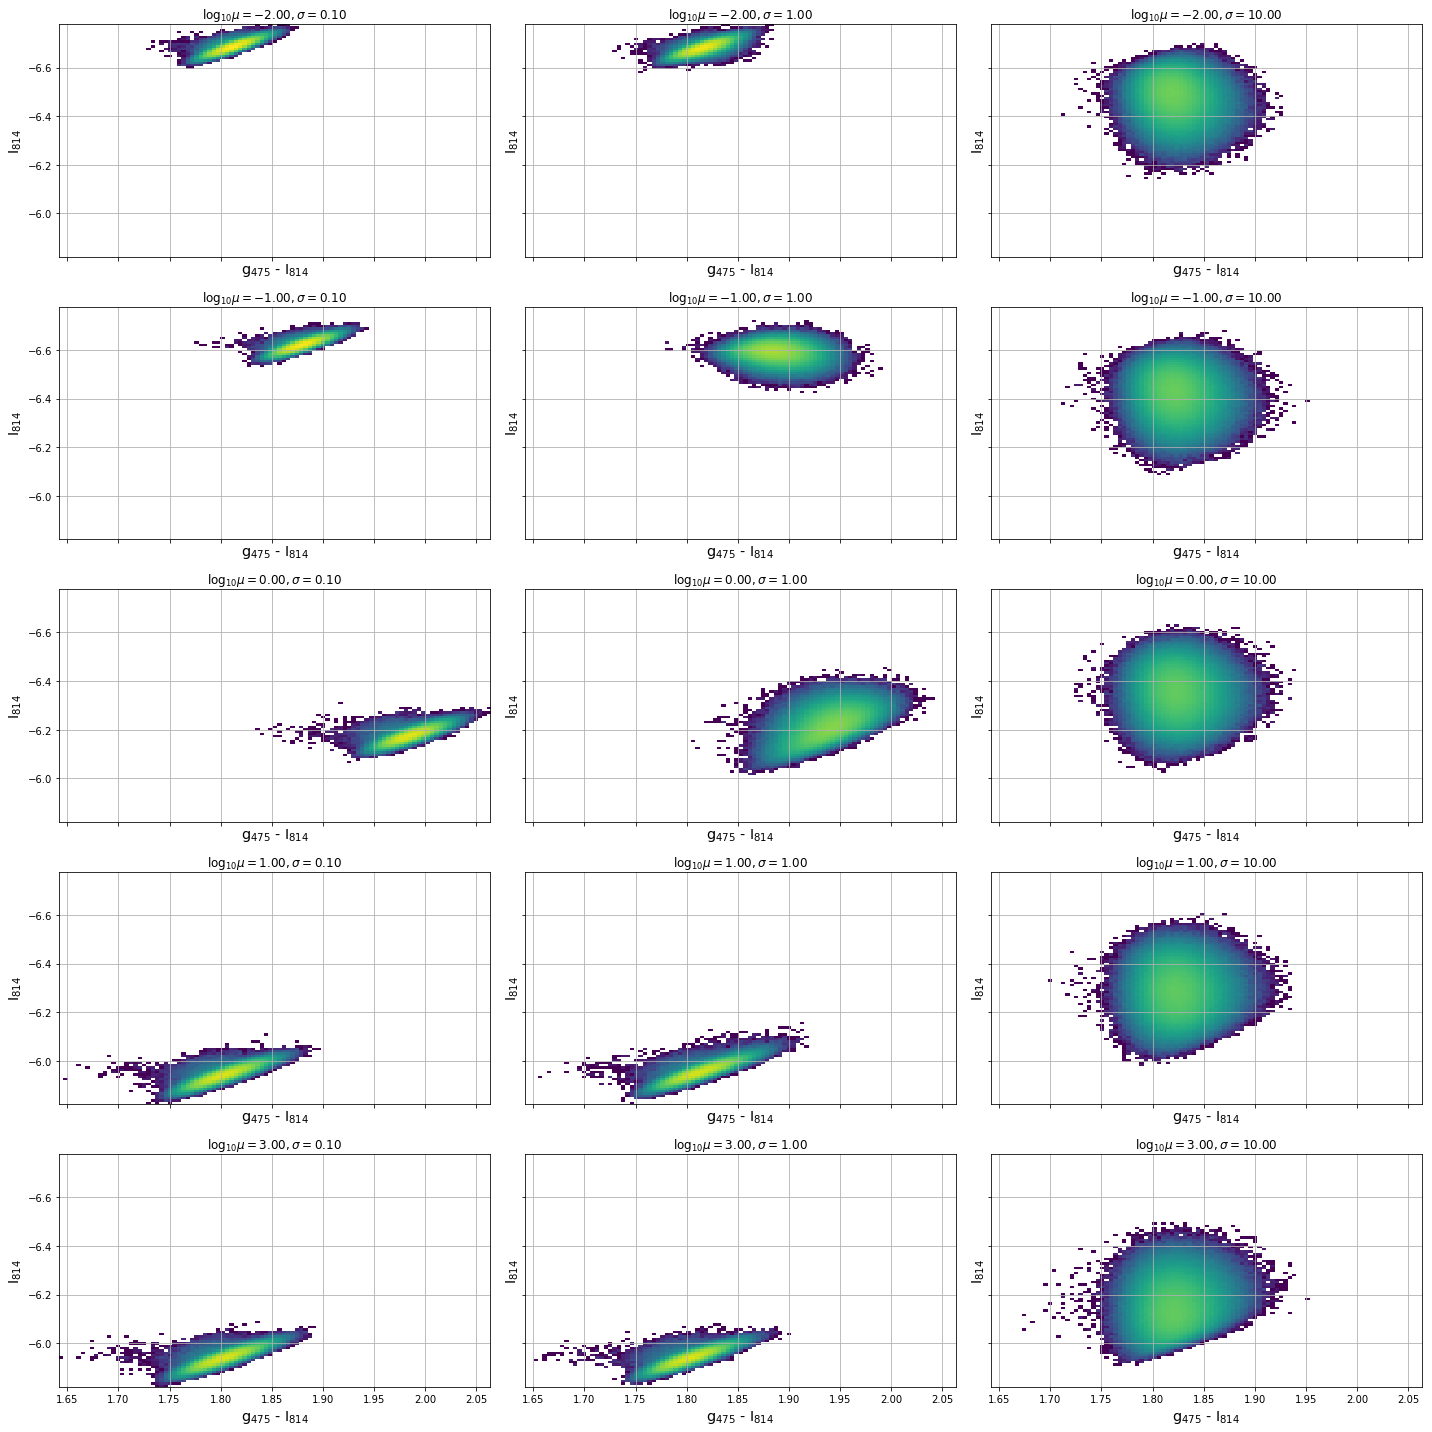

In [23]:
fig, axes = plt.subplots(ncols=nc, nrows=nr, figsize=(20, 20), sharex=True, sharey=True)
n = mpl.colors.LogNorm()
for ax, g, pcmd in zip(axes.flatten(), gals.flatten(), np.vstack(pcmds)):
    plt.subplot(ax)
    if np.any(np.isnan(pcmd)):
        continue
    plt.hist2d(pcmd[1], pcmd[0], bins=bins, norm=n)
    _, m, s = g.dust_model.get_params()
    ax.set_title(r'$\log_{10}\mu = $' + r'${:.2f}, \sigma = {:.2f}$'.format(m / np.log(10.), s))
for a in axes.flatten(): 
    a.grid(True)
    iso_model.plot_isochrone(gals[0][0], axes=a)
plt.tight_layout()
# plt.colorbar(ax=axes)